In [294]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input, models ,regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, BatchNormalization, Dense, Activation, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ELU
from tensorflow.keras.activations import gelu
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

import keras
from sklearn.metrics import brier_score_loss, roc_auc_score, accuracy_score, confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt

from math import isfinite

from collections import defaultdict
from tensorflow.keras.callbacks import Callback



https://purehost.bath.ac.uk/ws/portalfiles/portal/271643995/2303.06021v2.pdf

Machine learning for sports betting: should forecasting models be optimised for
accuracy or calibration?

(calibration led to higher profits)

In [ ]:
df_v2 = pd.read_csv(r'C:\Users\jcmar\my_files\SportsBetting\data\entire_odds_stats_v2.csv')

df_model = df_v2.copy()
df_model = df_model.dropna()
feat_select_cols = ['reach_blue', 'reach_red', 'reach_diff', 'age_diff', 'blue_age', 'red_age', 'height_blue', 'height_red', 'weight_class', 'total_bonus_red', 'total_bonus_blue',
                      'total_bonus_diff', 'reverse_pr_blue', 'reverse_pr_red', 'total_td_defended_diff', 'red_td_landed_total',
                      'blue_td_landed_total', 'red_td_defended_total', 'blue_td_defended_total', 'total_td_landed_diff', 'red_kd_total', 'blue_kd_total', 'kd_total_diff', 'math_red', 
                     'math_blue', 'months_since_red', 'months_since_blue', 'months_since_diff', 'red_win_streak', 'red_lose_streak', 'blue_win_streak', 
                     'blue_lose_streak', 'win_pct_red', 'win_pct_blue', 'num_fights_red', 'num_fights_blue', 'num_wins_red', 'num_wins_blue', 
                     'num_losses_red', 'num_losses_blue', 'num_fights_diff', 'win_streak_diff', 'lose_streak_diff', 'wins_diff', 'losses_diff', 'decision_wins_red', 'ko_wins_red', 
                     'sub_wins_red', 'decision_wins_blue', 'ko_wins_blue', 'sub_wins_blue', 'decision_wins_diff', 'ko_wins_diff',
                      'sub_wins_diff', 'open_blue', 'open_red', 'red_fav_counts', 'red_dog_counts', 'blue_fav_counts', 'blue_dog_counts']

today = pd.Timestamp.today()
df_v2['date'] = pd.to_datetime(df_v2['date'])
df_v2['event_age'] = (today - df_v2['date']).dt.days


In [418]:
def split_red_blue_features(df: pd.DataFrame):

    red_cols = [c for c in df.columns if "red" in c]
    blue_cols = [c for c in df.columns if "blue" in c]
    diff_cols = [c for c in df.columns if "diff" in c]

    # Construct red dataframe
    red_df = df[red_cols + diff_cols].copy()
    red_df['event_age'] = df['event_age']

    # Construct blue dataframe
    blue_df = df[blue_cols].copy()
    for c in diff_cols:
        blue_df[c] = -df[c]  # negate diffs for blue
    
    blue_df['event_age'] = df['event_age']
    # Update blue_cols to include diffs as well
    blue_cols = blue_cols + diff_cols

    return red_df, blue_df, red_cols + diff_cols, blue_cols

def split_fav_dog(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits dataset into favorite (fav) and underdog (dog) based on open odds.
    Standardizes column names to fav_* and dog_*.
    Adjusts 'diff' columns so that they are always (fav - dog).
    
    Args:
        df (pd.DataFrame): Input dataframe with 'open_red' and 'open_blue'.
    
    Returns:
        fav_df (pd.DataFrame): Rows corresponding to the favorite (fav_* + diff_*).
        dog_df (pd.DataFrame): Rows corresponding to the underdog (dog_* + diff_*).
    """
    fav_rows = []
    dog_rows = []

    df = df.copy()
    df = df.drop(columns=['red_fav_counts', 'red_dog_counts', 'blue_fav_counts', 'blue_dog_counts'])

    for _, row in df.iterrows():
        # --- case: red is favorite ---
        if row["open_red"] < row["open_blue"]:
            fav_row = {col.replace("red", "fav"): row[col] for col in row.index if "red" in col}
            dog_row = {col.replace("blue", "dog"): row[col] for col in row.index if "blue" in col}
            diff_row = {col.replace("diff", "diff"): row[col] for col in row.index if "diff" in col}

        # --- case: blue is favorite ---
        elif row["open_blue"] < row["open_red"]:
            fav_row = {col.replace("blue", "fav"): row[col] for col in row.index if "blue" in col}
            dog_row = {col.replace("red", "dog"): row[col] for col in row.index if "red" in col}
            diff_row = {col.replace("diff", "diff"): -row[col] for col in row.index if "diff" in col}

        # --- case: tie → red as favorite ---
        else:
            fav_row = {col.replace("red", "fav"): row[col] for col in row.index if "red" in col}
            dog_row = {col.replace("blue", "dog"): row[col] for col in row.index if "blue" in col}
            diff_row = {col.replace("diff", "diff"): row[col] for col in row.index if "diff" in col}
        
        fav_row['event_age'] = row['event_age']
        dog_row['event_age'] = row['event_age']

        fav_row.update(diff_row)
        dog_row.update(diff_row)

        fav_rows.append(fav_row)
        dog_rows.append(dog_row)
    
    fav_df = pd.DataFrame(fav_rows)
    dog_df = pd.DataFrame(dog_rows)

    
    y_fav_dog = []
    for _, row in df.iterrows():
        # Determine who is favorite
        if row['open_red'] <= row['open_blue']:  # red is fav or tie → red fav
            fav_won = 1 if row['winner'] == 1 else 0
        else:  # blue is fav
            fav_won = 1 if row['winner'] == 0 else 0
        
        y_fav_dog.append(fav_won)
    print(df['event_age'].isna().sum())
    return fav_df, dog_df, np.array(y_fav_dog)

In [419]:
devig_cols = ['dec_fair_close1_blue',
'dec_fair_close2_blue',
'dec_fair_open_blue',
'dec_fair_close1_red',
'dec_fair_close2_red',
'dec_fair_open_red',

'probs_fair_open_red',
'probs_fair_close1_red',
'probs_fair_close2_red',

'probs_fair_open_blue',
'probs_fair_close1_blue',
'probs_fair_close2_blue']

extra_cols = ['sigstrikes_absorbed_pm_blue','sigstrikes_absorbed_pm_red','sigstrikes_pm_blue','sigstrikes_pm_red',
              'red_elo', 'blue_elo', 'elo_diff','red_glicko', 'blue_glicko', 'red_glicko_rd', 'blue_glicko_rd', 
              'glicko_rd_diff','glicko_diff']

extra_cols = ['red_elo', 'blue_elo', 'elo_diff', 'glicko_rd_diff']

model_cols = feat_select_cols + devig_cols + ['red_fav_counts', 'red_dog_counts', 'blue_fav_counts', 'blue_dog_counts'] + ['winner','red_fighter','blue_fighter','date','event_age']
final_df = df_model[df_model['winner'] != 2]

model_dat = final_df[model_cols]
model_dat = model_dat.dropna()
copy_df = model_dat.copy()

print('AFTER NA SHAPE: ', model_dat.shape)

le = LabelEncoder()
# xgb_dat['event_country'] = le.fit_transform(xgb_dat['event_country'])
model_dat['weight_class'] = le.fit_transform(model_dat['weight_class'])

mm_scaler = MinMaxScaler()
cat_cols = model_dat.select_dtypes(include=['object', 'category']).columns.tolist()
num_categorical = model_dat.select_dtypes(include=['object']).shape[1]
print(f"Number of categorical columns: {num_categorical}")
numerical_cols = model_dat.columns.difference(cat_cols)
model_dat[numerical_cols] = mm_scaler.fit_transform(model_dat[numerical_cols])

train_len = int(model_dat.shape[0] * .85)
df_copy_train = final_df[model_cols].dropna().iloc[:train_len].copy()

train_dat = model_dat.iloc[:train_len]
test_dat = model_dat.iloc[train_len:]

X_train = train_dat.drop(columns=['winner','red_fighter','blue_fighter','date'])
y_train = train_dat['winner']

X_test = test_dat.drop(columns=['winner','red_fighter','blue_fighter','date'])
y_test = test_dat['winner']


AFTER NA SHAPE:  (5004, 81)
Number of categorical columns: 3


In [382]:
from sklearn.ensemble import IsolationForest

# Example: Assume df is your dataset
# df = pd.read_csv("your_data.csv")

def remove_outliers_isoforest(X_train, y_train, contamination=0.05, random_state=42):
    """
    Removes outliers from X_train and y_train using Isolation Forest.
    
    Args:
        X_train (pd.DataFrame or np.ndarray): Training features
        y_train (pd.Series or np.ndarray): Training labels
        contamination (float): proportion of outliers to remove
        random_state (int): random seed
    
    Returns:
        X_train_clean, y_train_clean: cleaned features and labels
    """
    iso = IsolationForest(contamination=contamination, random_state=random_state)
    preds = iso.fit_predict(X_train)  # -1 = outlier, 1 = inlier
    
    mask = preds == 1
    X_train_clean = X_train[mask]
    y_train_clean = y_train[mask]
    
    return X_train_clean, y_train_clean
X_train_clean, y_train_clean  = remove_outliers_isoforest(X_train, y_train)

In [ ]:
pca = PCA(n_components=X_train.shape[1])
X_pca = pca.fit_transform(X_train)
# print("Explained variance ratio:", pca.explained_variance_ratio_)

# Outlier detection via reconstruction error
X_reconstructed = pca.inverse_transform(X_pca)
reconstruction_error = np.linalg.norm(X_train - X_reconstructed, axis=1)

outlier_threshold = np.percentile(reconstruction_error, 98.5)  # top 5% as outliers
outliers = np.where(reconstruction_error > outlier_threshold)[0]
outlier_idx = X_train.index[outliers]

# Drop them
X_train_clean = X_train.drop(index=outlier_idx)
y_train_clean = y_train.drop(index=outlier_idx)

red_train, blue_train, red_cols, blue_cols = split_red_blue_features(X_train_clean)
red_test, blue_test, _, _ = split_red_blue_features(X_test)

fav_train, dog_train, y_favdog_train = split_fav_dog(pd.concat([X_train_clean,  y_train_clean],axis=1, ignore_index=False))
fav_test, dog_test, y_favdog_test = split_fav_dog(pd.concat([X_test, y_test],axis=1, ignore_index=False))


In [420]:
red_train, blue_train, red_cols, blue_cols = split_red_blue_features(X_train)
red_test, blue_test, _, _ = split_red_blue_features(X_test)

fav_train, dog_train, y_favdog_train = split_fav_dog(pd.concat([X_train, y_train],axis=1, ignore_index=False))
fav_test, dog_test, y_favdog_test = split_fav_dog(pd.concat([X_test, y_test],axis=1, ignore_index=False))

print(red_test.shape, blue_test.shape, red_train.shape, blue_train.shape)
print(fav_test.shape, dog_test.shape, fav_train.shape, dog_train.shape)

0
0
(751, 50) (751, 50) (4253, 50) (4253, 50)
(751, 42) (751, 42) (4253, 42) (4253, 42)


In [397]:
class FullTrainAccuracyCallback(Callback):
    def __init__(self, train_data, train_labels):
        super().__init__()
        self.train_data = train_data
        self.train_labels = train_labels

    def on_epoch_end(self, epoch, logs=None):
        # Predict on full training set (Dropout off, BatchNorm uses running averages)
        y_pred_prob = self.model.predict(self.train_data, verbose=0)
        y_pred = (y_pred_prob >= 0.5).astype(int).flatten()
        train_acc = np.mean(y_pred == self.train_labels)
        print(f"Full Train Accuracy: {train_acc:.4f}")

In [501]:
def build_dual_subnetwork_model(input_dim_class0, input_dim_class1, dropout_rate=0.2):
    # Subnetwork for class 0 features
    input0 = Input(shape=(input_dim_class0,), name="class0_input")

    x0 = layers.Dense(64)(input0)
    x0 = layers.BatchNormalization(momentum=0.96)(x0)
    x0 = layers.Activation("relu")(x0)
    # x0 = layers.ELU(alpha=0.1)(x0)  
    x0 = layers.Dropout(dropout_rate)(x0)

    x0 = layers.Dense(32)(x0)
    x0 = layers.BatchNormalization(momentum=0.92)(x0)
    # x0 = layers.Activation("relu")(x0)
    x0 = layers.ELU(alpha=0.32)(x0)  
    x0 = layers.Dropout(dropout_rate)(x0)

    # Subnetwork for class 1 features
    input1 = Input(shape=(input_dim_class1,), name="class1_input")
    
    x1 = layers.Dense(64)(input1)
    x1 = layers.BatchNormalization(momentum=0.96)(x1)
    # x1 = layers.ELU(alpha=0.3)(x1)  
    x1 = layers.Activation("relu")(x1)
    x1 = layers.Dropout(dropout_rate)(x1)

    x1 = layers.Dense(32)(x1)
    x1 = layers.BatchNormalization(momentum=0.92)(x1)
    x1 = layers.ELU(alpha=0.32)(x1)  
    # x1 = layers.Activation("relu")(x1)
    x1 = layers.Dropout(dropout_rate)(x1)

    # Concatenate embeddings
    combined = layers.Concatenate()([x0, x1])

    z = layers.Dense(32)(combined)
    z = layers.BatchNormalization(momentum=0.92)(z)
    z = layers.ELU(alpha=0.325)(z)  
    # z = layers.Activation('relu')(z)
    z = layers.Dropout(dropout_rate)(z)

    # z = layers.Dense(16)(z)
    # z = layers.BatchNormalization(momentum=0.9)(z)
    # # z = layers.ELU(alpha=0.3)(z)  
    # z = layers.Activation('relu')(z)
    # z = layers.Dropout(dropout_rate)(z)

    output = layers.Dense(1, activation="sigmoid")(z)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

model = build_dual_subnetwork_model(
    input_dim_class0=fav_train.shape[1],
    input_dim_class1=dog_train.shape[1]
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=10,
    min_lr=1e-6
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(.0003),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
full_train_acc_callback = FullTrainAccuracyCallback([fav_train, dog_train], y_favdog_train)

history = model.fit(
    [fav_train, dog_train], y_favdog_train,
    validation_data=([fav_test, dog_test], y_favdog_test),
    epochs=100,
    batch_size=16,
    verbose=1,
    callbacks=[reduce_lr, full_train_acc_callback]
)

Epoch 1/100
248/266 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5323 - loss: 0.7665Full Train Accuracy: 0.6445
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5344 - loss: 0.7641 - val_accuracy: 0.6711 - val_loss: 0.6064 - learning_rate: 3.0000e-04
Epoch 2/100
257/266 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6082 - loss: 0.6911Full Train Accuracy: 0.6544
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6086 - loss: 0.6903 - val_accuracy: 0.6791 - val_loss: 0.6044 - learning_rate: 3.0000e-04
Epoch 3/100
239/266 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6243 - loss: 0.6598Full Train Accuracy: 0.6661
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6240 - loss: 0.6600 - val_accuracy: 0.6778 - val_loss: 0.5986 - learning_rate: 3.0000e-04
Epoch 4/100
251/266 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6227 - loss: 0.6492Full Train Accuracy: 0.6647
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6228 - loss: 0.6496 - val_accuracy: 0.6738 - val_loss:

In [333]:
nn_probs = model.predict([fav_train, dog_train])
nn_preds = (nn_probs > 0.5).astype(int)


133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step


In [179]:
from itertools import combinations


In [531]:
def build_full_combination_pyramid(input_dim_red, input_dim_blue, input_dim_fav, input_dim_dog, dropout_rate=0.2):
    # --- Individual subnetworks ---
    def shallow_subnet(input_dim, name_prefix):
        inp = Input(shape=(input_dim,), name=f"{name_prefix}_input")
        x = layers.Dense(32)(inp)
        x = layers.BatchNormalization(momentum=0.96)(x)
        # x = layers.Activation("relu")(x)
        x = layers.ELU(alpha=.3)(x)
        x = layers.Dropout(dropout_rate)(x)
        return inp, x

    # Create subnetworks
    red_input, red_feat = shallow_subnet(input_dim_red, "red")
    blue_input, blue_feat = shallow_subnet(input_dim_blue, "blue")
    fav_input, fav_feat = shallow_subnet(input_dim_fav, "fav")
    dog_input, dog_feat = shallow_subnet(input_dim_dog, "dog")

    features = {
        "red": red_feat,
        "blue": blue_feat,
        "fav": fav_feat,
        "dog": dog_feat
    }

    # --- All pairwise concatenations ---
    concat_features = {}
    for a, b in combinations(features.keys(), 2):
        concat = layers.Concatenate(name=f"{a}_{b}_concat")([features[a], features[b]])

        # concat = layers.Dense(128)(concat)
        # concat = layers.BatchNormalization(momentum=0.96)(concat)
        # # concat = layers.ELU(alpha=0.3)(concat)
        # concat = layers.Activation("relu")(concat)
        # concat = layers.Dropout(dropout_rate)(concat)

        concat = layers.Dense(32)(concat)
        concat = layers.BatchNormalization(momentum=0.95)(concat)
        concat = layers.ELU(alpha=.32)(concat)
        concat = layers.Dropout(dropout_rate)(concat)

        concat_features[f"{a}_{b}"] = concat

    # --- Final concatenation of all pairwise combinations ---
    all_concat = layers.Concatenate(name="final_concat")(
        list(concat_features.values())
    )

    # all_concat = layers.Dense(128)(all_concat)
    # all_concat = layers.BatchNormalization(momentum=0.9)(all_concat)
    # all_concat = layers.ELU(alpha=0.3)(all_concat)
    # all_concat = layers.Dropout(dropout_rate)(all_concat)

    all_concat = layers.Dense(64)(all_concat)
    all_concat = layers.BatchNormalization(momentum=0.92)(all_concat)
    # all_concat = layers.ELU(alpha=0.3)(all_concat)
    all_concat = layers.Activation("relu")(all_concat)
    all_concat = layers.Dropout(dropout_rate)(all_concat)

    all_concat = layers.Dense(32)(all_concat)
    all_concat = layers.BatchNormalization(momentum=0.92)(all_concat)
    all_concat = layers.ELU(alpha=0.3)(all_concat)
    # all_concat = layers.Activation("relu")(all_concat)
    all_concat = layers.Dropout(dropout_rate)(all_concat)

    # all_concat = layers.Dense(16)(all_concat)
    # all_concat = layers.BatchNormalization(momentum=0.92)(all_concat)
    # # all_concat = layers.ELU(alpha=0.3)(all_concat)
    # all_concat = layers.Activation("relu")(all_concat)
    # all_concat = layers.Dropout(dropout_rate)(all_concat)


    output = layers.Dense(1, activation="sigmoid", name="final_output")(all_concat)

    # Model
    model = Model(
        inputs=[red_input, blue_input, fav_input, dog_input],
        outputs=[output] 
    )
    
    return model

In [532]:
model = build_full_combination_pyramid(
    input_dim_red=red_train.shape[1],
    input_dim_blue=blue_train.shape[1],
    input_dim_fav=fav_train.shape[1],
    input_dim_dog=dog_train.shape[1]
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=10,
    min_lr=1e-6
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(.0003),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
# full_train_acc_callback = FullTrainAccuracyCallback([fav_train, dog_train], y_favdog_train)

history = model.fit(
    [red_train, blue_train, fav_train, dog_train], y_train,
    validation_data=([red_test, blue_test, fav_test, dog_test], y_test),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[reduce_lr]
)

Epoch 1/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5745 - loss: 0.7485 - val_accuracy: 0.6791 - val_loss: 0.6138 - learning_rate: 3.0000e-04
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6133 - loss: 0.6838 - val_accuracy: 0.6738 - val_loss: 0.6144 - learning_rate: 3.0000e-04
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6311 - loss: 0.6497 - val_accuracy: 0.6791 - val_loss: 0.6050 - learning_rate: 3.0000e-04
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6336 - loss: 0.6464 - val_accuracy: 0.6751 - val_loss: 0.6101 - learning_rate: 3.0000e-04
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6449 - loss: 0.6397 - val_accuracy: 0.6738 - val_loss: 0.6063 - learning_rate: 3.0000e-04
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6409 - loss: 0.6433 - val_accuracy: 0.6764 - val_loss: 0.6066 - learning_rate: 3.0000e-04
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


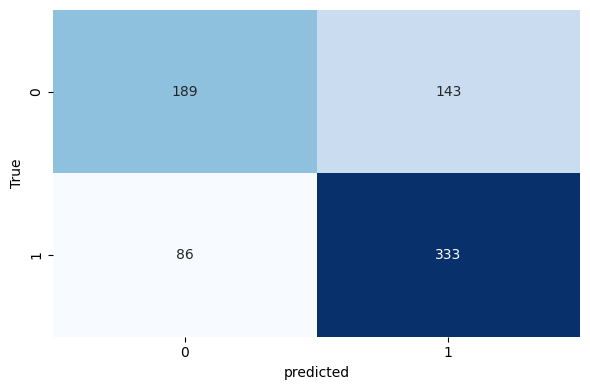

In [613]:
nn_probs = model.predict([red_test, blue_test, fav_test, dog_test])
nn_preds = (nn_probs > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, nn_preds)

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('predicted')
plt.ylabel('True')
plt.tight_layout()

In [ ]:
nn_probs_2d = np.vstack([1 - nn_probs.ravel(), nn_probs.ravel()]).T


In [ ]:
df_results = final_df[model_cols].dropna().iloc[train_len:].copy()
df_results['blue_probs'] = nn_probs_2d[:,0]
df_results['red_probs'] = nn_probs_2d[:,1]
df_results['pred_winner'] = np.where(nn_probs >=.5, 1, 0)
df_results['correct_pred'] = np.where(df_results['winner'] == df_results['pred_winner'], 1, 0)


In [ ]:
test_answers = pd.DataFrame()
copy_final_df = final_df.copy()

test_answers['blue_probs'] = nn_probs_2d[:,0]
test_answers['red_probs'] = nn_probs_2d[:,1]
test_answers['pred_winner'] = np.argmax(nn_probs_2d, axis=1)

test_answers['winner'] = copy_final_df.iloc[train_len:]['winner'].reset_index(drop=True)
# test_answers['winner'] = y_test.reset_index(drop=True)
test_answers['correct_pred'] = (test_answers['pred_winner'] == test_answers['winner']).astype(int)
test_answers['event_dates'] = copy_final_df.iloc[train_len:]['date'].reset_index(drop=True)

test_answers['open_red'] = copy_final_df.iloc[train_len:]['open_red'].reset_index(drop=True)
test_answers['open_blue'] = copy_final_df.iloc[train_len:]['open_blue'].reset_index(drop=True)

test_answers['close1_red'] = copy_final_df.iloc[train_len:]['close1_red'].reset_index(drop=True)
test_answers['close1_blue'] = copy_final_df.iloc[train_len:]['close1_blue'].reset_index(drop=True)

test_answers['close2_red'] = copy_final_df.iloc[train_len:]['close2_red'].reset_index(drop=True)
test_answers['close2_blue'] = copy_final_df.iloc[train_len:]['close2_blue'].reset_index(drop=True)

test_answers['event_dates'] = copy_final_df.iloc[train_len:]['date'].reset_index(drop=True)
test_answers['red_fighter'] = copy_final_df.iloc[train_len:]['red_fighter'].reset_index(drop=True)
test_answers['blue_fighter'] = copy_final_df.iloc[train_len:]['blue_fighter'].reset_index(drop=True)

test_answers.info()
print(test_answers.info())

test_answers.to_csv(r'C:\Users\jcmar\my_files\SportsBetting\data\model_results_dualnn.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 751 entries, 0 to 750
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   blue_probs    751 non-null    float32
 1   red_probs     751 non-null    float32
 2   pred_winner   751 non-null    int64  
 3   winner        751 non-null    int64  
 4   correct_pred  751 non-null    int64  
 5   event_dates   751 non-null    object 
 6   open_red      751 non-null    float64
 7   open_blue     751 non-null    float64
 8   close1_red    751 non-null    float64
 9   close1_blue   751 non-null    float64
 10  close2_red    751 non-null    float64
 11  close2_blue   751 non-null    float64
 12  red_fighter   751 non-null    object 
 13  blue_fighter  751 non-null    object 
dtypes: float32(2), float64(6), int64(3), object(3)
memory usage: 76.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 751 entries, 0 to 750
Data columns (total 14 columns):
 #   Column        Non-Null

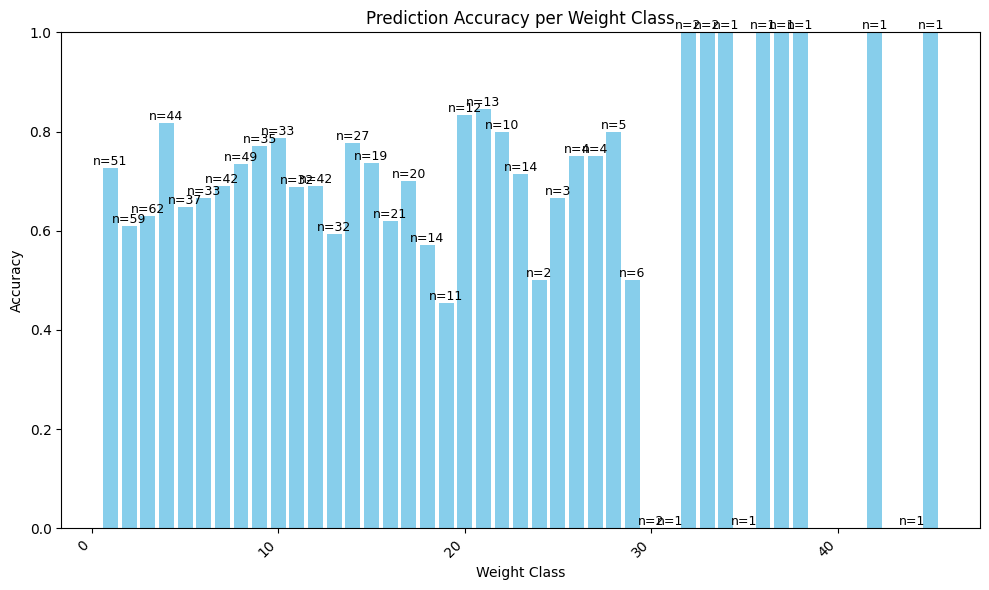

In [623]:
grouped = df_results.groupby("num_fights_red")["correct_pred"].agg(["mean", "count"])

# --- Plot ---
plt.figure(figsize=(10, 6))
bars = plt.bar(grouped.index, grouped["mean"], color="skyblue")

plt.title("Prediction Accuracy per Weight Class")
plt.ylabel("Accuracy")
plt.xlabel("Weight Class")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")

# --- Annotate with sample counts ---
for bar, count, acc in zip(bars, grouped["count"], grouped["mean"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,   # x-position
        bar.get_height(),                    # y-position (top of bar)
        f"n={count}",                        # text
        ha="center", va="bottom", fontsize=9
    )

plt.tight_layout()
plt.show()

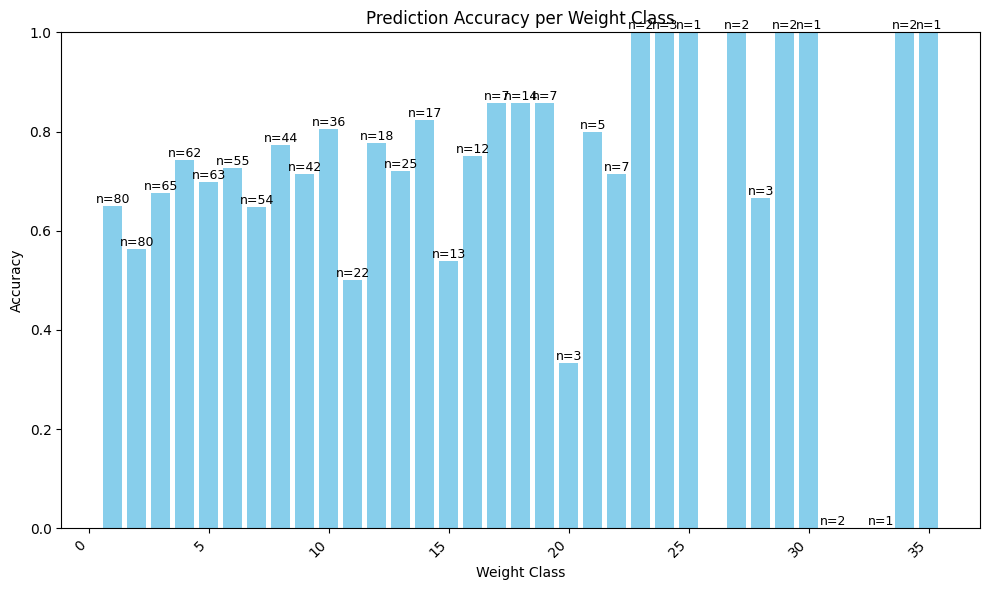

In [624]:
grouped = df_results.groupby("num_fights_blue")["correct_pred"].agg(["mean", "count"])

# --- Plot ---
plt.figure(figsize=(10, 6))
bars = plt.bar(grouped.index, grouped["mean"], color="skyblue")

plt.title("Prediction Accuracy per Weight Class")
plt.ylabel("Accuracy")
plt.xlabel("Weight Class")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")

# --- Annotate with sample counts ---
for bar, count, acc in zip(bars, grouped["count"], grouped["mean"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,   # x-position
        bar.get_height(),                    # y-position (top of bar)
        f"n={count}",                        # text
        ha="center", va="bottom", fontsize=9
    )

plt.tight_layout()
plt.show()